# **Waze User Churn: Tree‑Based Machine Learning**

This notebook builds and evaluates two tree‑based models—Random Forest and XGBoost—to predict Waze user churn based on behavioral and usage features. The focus is on model performance (with recall as the primary metric), feature importance, and how these models complement the earlier logistic regression baseline.

The workflow includes:
- Feature engineering and encoding for tree‑based models  
- Model training with cross‑validated hyperparameter tuning  
- Model selection using a validation set and final evaluation on a held‑out test set  
- Interpretation of model performance and feature importance in a business context  

### **Tree‑based modeling overview**

Decision tree–based models split the feature space by asking a sequence of if/else questions on features (for example, “is `drives` > threshold?”) and assign churn probabilities to each resulting region. Random Forest builds many such trees on bootstrapped samples and averages their predictions to reduce variance, while XGBoost builds trees sequentially to correct previous errors, often achieving stronger performance at the cost of greater complexity and interpretability.


## **Imports and data loading**

Core libraries for data manipulation, visualization, and model training are imported, and the Waze churn dataset is loaded into a working DataFrame.

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns in DataFrame outputs
pd.set_option('display.max_columns', None)

# Import packages for model selection and evaluation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# Tree-based classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# Model persistence
import pickle

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


The raw Waze dataset is first loaded into `df0` for inspection, then copied into `df` for feature engineering so the original data remains unchanged.

## **Feature engineering**

Previous EDA and statistical modeling identified usage‑based predictors and highlighted derived features related to intensity and recency. This section engineers those features for tree‑based models, then handles missing labels and encodes categorical variables.


In [4]:
# Work on a copy of the original data
df = df0.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**

Average kilometers driven per driving day captures driving intensity for users who drove at least once in the month and helps distinguish casual drivers from very heavy users.

In [6]:
# Mean kilometers per driving day
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']

# Inspect distribution
df['km_per_driving_day'].describe()

/Users/shreyasj/Work/GitHub Repos/GADA Waze Project/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [7]:
# replace infinite values (from 0 driving days) with 0 to keep statistics valid
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day']=0
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**
`percent_sessions_in_last_month` represents the fraction of a user’s lifetime sessions that occurred in the last observed month, highlighting recent engagement intensity and behavior changes leading up to churn.

In [8]:
# Share of lifetime sessions that occurred in the last month
df['percent_sessions_in_last_month'] = df['sessions']/df['total_sessions']

# Inspect distribution
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**
A binary `professional_driver` flag is used to approximate heavy, likely professional users (≥60 drives and ≥15 driving days in the last month), based on domain‑informed thresholds and earlier EDA showing lower churn among high‑activity users.

In [9]:
# Flag high‑intensity "professional" drivers
df['professional_driver'] = np.where((df['drives']>=60) & (df['driving_days']>=15), 1, 0)

#### **`total_sesions_per_day`**
`total_sesions_per_day` (as named in the data) estimates the average number of sessions per day since onboarding, capturing long‑term engagement intensity over a user’s lifetime.

In [10]:
# Average sessions per day since onboarding
df['total_sesions_per_day'] = df['total_sessions']/df['n_days_after_onboarding']
df['total_sesions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sesions_per_day, dtype: float64

#### **`km_per_hour`**
`km_per_hour` summarizes average driving speed over the month, combining distance and time into a single efficiency metric that may reflect different driving contexts (for example, highway vs. urban driving).

In [11]:
# Average kilometers per hour across all drives in the last month
df['km_per_hour'] = df['driven_km_drives']/(df['duration_minutes_drives']/60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

#### **`km_per_drive`**
`km_per_drive` represents average distance per trip, providing another view on driving intensity per drive. As with other ratio features, division by zero for users with no drives produces infinite values, which are recoded to 0 for stability.

In [12]:
# Average kilometers per drive in the last month
df['km_per_drive'] = df['driven_km_drives']/df['drives']
df['km_per_drive'].describe()

/Users/shreyasj/Work/GitHub Repos/GADA Waze Project/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [13]:
# Replace infinite values (from 0 drives) with 0
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**
`percent_of_sessions_to_favorite` approximates the share of sessions spent navigating to saved favorite locations, serving as a proxy for how often users travel to familiar vs. new places, which may relate to exploration and dependence on navigation.

In [14]:
# Share of sessions used to navigate to favorite places
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1']+df['total_navigations_fav2'])/df['total_sessions']

# Inspect distribution
df['percent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

### **Handle missing churn labels**

As in earlier notebooks, rows with missing churn labels (`label`) are dropped because they represent <5% of observations and show no clear non‑random pattern.

In [15]:
# Drop rows with missing churn labels
df = df.dropna(subset=['label'])

### **Outliers and tree‑based models**

Many usage variables contain outliers, but tree‑based models are generally robust to extreme values, so no additional outlier imputation is applied for this stage of modeling.

### **Variable encoding**

#### **Device**

The `device` feature (Android vs. iPhone) is encoded as a binary numeric predictor `device2` to be usable in scikit‑learn models.

In [16]:
# Binary‑encode device: Android = 0, iPhone = 1
df['device2'] = np.where(df['device']=='Android',0,1)
df[['device','device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


#### **Target variable**

The churn label is encoded as `label2`, where 0 represents retained users and 1 represents churned users, preserving the original string labels for reference.

In [17]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='retained',0,1)
df[['label','label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Feature set definition**

Tree‑based models can handle multicollinearity, so only the non‑informative identifier `ID` is dropped. The original `device` column is also excluded later in favor of the encoded `device2` feature.

In [18]:
# Drop non‑informative ID column
df = df.drop(['ID'], axis=1)

### **Evaluation metric and class balance**

The churn label is moderately imbalanced: about 18% of users churn and 82% are retained, which is manageable without explicit resampling. Because the main business risk is missing at‑risk users rather than incorrectly flagging some retained users, recall is used as the primary evaluation metric for model selection.


In [19]:
# Get class balance of 'label' column
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

## **Modeling workflow**

The final modeling dataset contains 14,299 samples, enough to support a standard train/validation/test workflow for model training and selection. The process is:

1. Split the data into train/validation/test sets (60/20/20).  
2. Fit models and tune hyperparameters on the training set using cross‑validation.  
3. Select a champion model based on validation recall.  
4. Evaluate the champion model on the held‑out test set to estimate performance on new data.  



![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

### **Train/validation/test split**

Features and target are defined and then split into 60/20/20 train, validation, and test sets using stratified sampling to preserve class balance in each partition.

In [20]:
# Feature matrix (exclude label columns and original device)
X = df.drop(columns=['label', 'label2','device'])

# Binary target vector
y = df['label2']

# Initial 80/20 split into interim train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Split interim train into final train (60%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_tr,y_tr, stratify=y_tr, test_size=0.25, random_state=42)

# Verify partition sizes
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


### **Random forest**

A Random Forest classifier is tuned with a small hyperparameter grid using cross‑validated GridSearchCV, optimizing for recall while also tracking precision, F1, and accuracy. Random Forest builds an ensemble of decision trees on bootstrapped samples and averages their predictions, which reduces variance and typically improves generalization compared with a single decision tree.

In [21]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameters to evaluate in cross‑validation
cv_params = {'max_depth':[None],
            'max_features':[1.0],
            'max_samples':[1.0],
            'min_samples_leaf': [2],
            'min_samples_split': [2],
            'n_estimators':[300]}

# Metrics to record during grid search
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Cross‑validated grid search, refitting on the model with best recall
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

The model is fit on the training data and the best cross‑validated recall score and hyperparameters are inspected.

In [22]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 1min 9s, sys: 208 ms, total: 1min 9s
Wall time: 1min 9s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None], 'max_features': [1.0], 'max_samples': [1.0], 'min_samples_leaf': [2], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['accuracy', 'precision', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'recall'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and pa

In [23]:
# Examine best score
rf_cv.best_score_

np.float64(0.12612597066436582)

In [24]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

The `make_results()` helper function summarizes cross‑validated accuracy, precision, recall, and F1 for the best model according to a chosen metric.

In [25]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

The `make_results()` helper function summarizes cross‑validated accuracy, precision, recall, and F1 for the best model according to a chosen metric.

In [26]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.472277,0.126126,0.198474,0.819675


Aside from accuracy, the recall and F1 scores are modest, but recall is already markedly higher than in the earlier logistic regression baseline while maintaining similar accuracy. Additional hyperparameter tuning could yield small gains, but the current configuration provides a reasonable benchmark.

### **XGBoost**

An XGBoost classifier is then tuned over a slightly richer hyperparameter grid, again optimizing for recall while tracking other metrics. XGBoost builds trees sequentially, where each new tree is trained to correct the residual errors of the previous ensemble, enabling the model to capture complex nonlinear relationships and interactions in the data.

In [27]:
# Instantiate the XGBoost classifier for binary classification
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Hyperparameters to evaluate in cross‑validation
cv_params = {'max_depth': [6,12],
            'min_child_weight': [3,5],
            'learning_rate': [0.01,0.1],
            'n_estimators': [300]}

# Metrics to record during grid search
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Cross‑validated grid search, refitting on the model with best recall
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [28]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 30.8 s, sys: 35.2 s, total: 1min 5s
Wall time: 23.9 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.1], 'max_depth': [6, 12], 'min_child_weight': [3, 5], 'n_estimators': [300]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['accuracy', 'precision', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'recall'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fo

In [29]:
# Examine best score
xgb_cv.best_score_

np.float64(0.17412424503882656)

In [30]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [31]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.472277,0.126126,0.198474,0.819675
0,XGB cv,0.441180,0.174124,0.249251,0.813965


The tuned XGBoost model achieves higher recall than both the logistic regression baseline and the random forest, while maintaining similar accuracy and precision.

## **Model selection on validation data**

The best random forest and XGBoost models from cross‑validation are evaluated on the validation set, and the model with higher recall is selected as the champion.

#### **Random forest**

In [32]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [33]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [34]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.472277,0.126126,0.198474,0.819675
0,XGB cv,0.441180,0.174124,0.249251,0.813965
0,RF val,0.442029,0.120316,0.189147,0.817133


Validation scores for the random forest drop slightly relative to cross‑validation results across all metrics, which is expected and suggests limited overfitting.

#### **XGBoost**



In [35]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.472277,0.126126,0.198474,0.819675
0,XGB cv,0.441180,0.174124,0.249251,0.813965
0,RF val,0.442029,0.120316,0.189147,0.817133
0,XGB val,0.395556,0.175542,0.243169,0.806294


The XGBoost model shows a similar small drop from cross‑validation to validation scores but still outperforms the random forest on recall, confirming it as the champion model.

## **Champion model evaluation on test data**

The champion XGBoost model is applied to the held‑out test set to estimate performance on new, unseen users.

In [36]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results,xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.472277,0.126126,0.198474,0.819675
0,XGB cv,0.441180,0.174124,0.249251,0.813965
0,RF val,0.442029,0.120316,0.189147,0.817133
0,XGB val,0.395556,0.175542,0.243169,0.806294
0,XGB test,0.416327,0.201183,0.271277,0.808392


On the held‑out test set, recall matches the validation result, while precision declines somewhat, leading to small drops in F1 and accuracy. This gap is within a reasonable range for generalization error and supports using the validation‑selected XGBoost model as a stable performance estimate.

### **Confusion matrix**

A confusion matrix summarizes the champion model’s churn predictions on the test set and highlights the trade‑off between correctly identifying churners and misclassifying retained users.

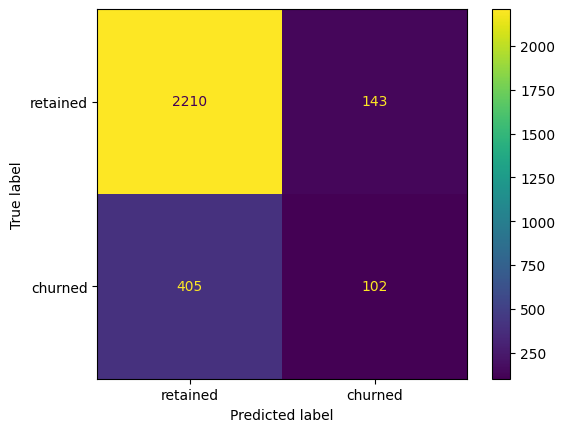

In [37]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['retained','churned'])
disp.plot();

The confusion matrix shows roughly three times as many false negatives as false positives, and the model correctly identifies about 16–17% of actual churners. This confirms that, even with improved recall over logistic regression, many at‑risk users remain undetected at the default decision threshold.


### **Feature importance**

Feature importance from the XGBoost model indicates which predictors contribute most strongly to churn predictions.

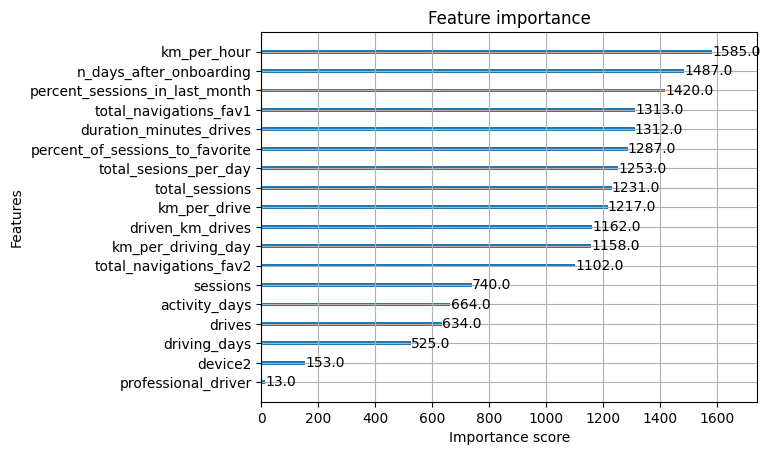

In [38]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model distributes importance across a broader set of predictors than the earlier logistic regression, which relied heavily on `activity_days`. Engineered features account for a majority of the top‑ranked predictors, underscoring how feature engineering can substantially improve model performance.

Differences in feature importance between models reflect complex interactions among predictors: a feature that appears weak in one model may still carry signal in combination with others in a more flexible algorithm. This reinforces the value of testing multiple model families before discarding features as uninformative.


## **Model insights and recommendations**

Across all models, XGBoost achieved the highest recall on validation and test data, followed by random forest, with logistic regression performing worst on recall but best on interpretability. This pattern is consistent with expectations: tree‑based ensembles typically capture more complex patterns at the expense of transparency, while generalized linear models provide clearer explanations with more limited flexibility.

- **Suitability for deployment:**  
  The tuned XGBoost model improves recall relative to logistic regression and random forest but still misses many churners and generates a notable number of false positives. It is more suitable as a decision‑support tool and experimentation baseline than as a standalone system for high‑stakes, automated retention decisions.

- **Train/validation/test split trade‑off:**  
  Using separate validation and test sets reduces the data available for training but enables unbiased model selection on validation data and a cleaner final performance estimate on the untouched test set. This structure improves confidence that the selected model will generalize to new users.

- **Logistic regression vs. tree‑based ensembles:**  
  Logistic regression offers straightforward interpretability via coefficients and clear directionality of effects, making it valuable for explaining drivers of churn. Tree‑based ensembles like random forest and XGBoost typically deliver stronger predictive performance, handle nonlinearities and interactions, and require fewer distributional assumptions, at the cost of interpretability.

- **Paths to improvement:**  
  Further gains are likely to come from richer feature engineering (for example, temporal trends, volatility of behavior, or route diversity), targeted class‑weighting or threshold tuning to prioritize recall, and incorporating additional data on drive‑level behavior and in‑app interactions.

- **Additional data needs:**  
  Drive‑level details (timing, route type, context), more granular app‑interaction logs (searches, reports, confirmations), and geographic or contextual features would help distinguish structural churn from temporary disengagement and support more precise intervention strategies.